In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# check if filename already exists, if so add number
def check_filename(filename):
    filename = "figs/" +  filename
    if os.path.exists(filename + ".png"):
        i = 1
        while True:
            new_filename = filename + "_" + str(i)
            if os.path.exists(new_filename + ".png"):
                i += 1
            else:
                return new_filename + ".png"
    else:
        return filename + ".png"
    
# save figure
def save_figure(fig, filename):
    filename = check_filename(filename)
    fig.savefig(filename)
    print(f'Figure saved as {filename}')

Satelli sampling means variance based sampling, but not a good measure for non-uniform distribution. Advantage: just extends series further if you want to increase number of samples
Parallelization of sampling --> batch run (concurrent)

# Added modules

In [3]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

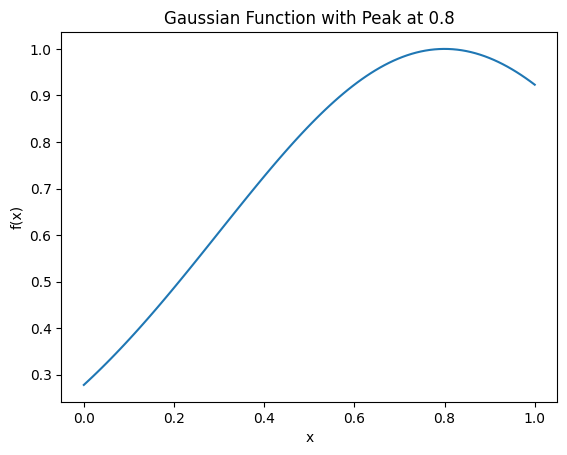

Figure saved as figs/Gaussian Function with Peak at 0.8_3.png


<Figure size 640x480 with 0 Axes>

In [4]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.8  # Peak in the middle
sigma = 0.5  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()

save_figure(plt, f'Gaussian Function with Peak at {mu}')

# Sobol Sensitivity Analysis

In [5]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [6]:
import modules as modules
import model as model
from model import Schelling

def schelling_SA(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for _ in range(num_runs):

        # initialize model
        models = Schelling(
            property_value_func=modules.property_value_quadrants,
            income_func=modules.income_func,
            desirability_func=modules.desirability_func,
            utility_func=modules.utility_func,
            price_func=modules.price_func,
            compute_similar_neighbours=modules.compute_similar_neighbours,
            calculate_gi_star = modules.calculate_gi_star,
            update_interested_agents_func = modules.update_interested_agents_concurrently,
            price_func_cap=modules.price_func_cap,
            height=20,
            width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=42)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()
        mean_desirability_entropy = np.mean(desirability_entropy[burn_in_period::])
    
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        # agent_entropy_std = model_data_entropy['Agent entropy'].std()
        mean_agent_entropy = np.mean(agent_entropy[burn_in_period::])
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        #utility_std = agent_data.groupby(level='Step')['Utility'].std()
    
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        #utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    mean_desirability = np.mean(overall_desirability_entropy)
    mean_agent = np.mean(overall_agent_entropy)
    mean_utility = np.mean(overall_utility)

    return mean_desirability, mean_agent, mean_utility

In [7]:
# Step 1: Problem definition
problem = {
    'num_vars': 6,
    'names': ['density', 'minority_pc', 'property_value_weight', 'alpha', 'mu_theta', 'sigma_theta'],
    'bounds': [[0,1], [0,1], [0,1], [0,1], [0,1], [0,1]]
}

# Step 2: Generate samples 
samples = saltelli.sample(problem, 25) 

In [8]:
# Step 3: evaluate the model under the different parameter settings 
# Define settings 
iterations = 30
model_steps = 30
burn_in = 5

# Initialize storage for measures
result_desirability = np.zeros([samples.shape[0]])
result_agent = np.zeros([samples.shape[0]])
result_utility = np.zeros([samples.shape[0]])

# load csv files
result_desirability = pd.read_csv('results/sa_desirability.csv', index_col=0).to_numpy().flatten()
result_agent = pd.read_csv('results/sa_agent.csv', index_col=0).to_numpy().flatten()
result_utility = pd.read_csv('results/sa_utility.csv', index_col=0).to_numpy().flatten()

# find the last row that is not 0.0
last_row = np.where(result_desirability == 0.0)[0][0]

In [9]:
def save_model(result_desirability, result_agent, result_utility):
    print('Saving model...')
    pd.DataFrame(result_desirability).to_csv('results/sa_desirability.csv')
    pd.DataFrame(result_agent).to_csv('results/sa_agent.csv')
    pd.DataFrame(result_utility).to_csv('results/sa_utility.csv')
    print('Model saved')
    return

def evaluate_model(samples, result_desirability, result_agent, result_utility, iterations, model_steps, burn_in, last_row=0):
    for i, X in enumerate(samples):
        print(f'Iteration {i+1} out of {samples.shape[0]}')
        if i < last_row:
            print('Already computed')
        else:
            results = schelling_SA(iterations, model_steps, burn_in, *X)
            result_desirability[i] = results[0]
            result_agent[i] = results[1]
            result_utility[i] = results[2]
            save_model(result_desirability, result_agent, result_utility)
    return

In [10]:
import multiprocessing as mp

# run evaluate model in parallel
def parallel_evaluate_model(samples, result_desirability, result_agent, result_utility, iterations, model_steps, burn_in, last_row):
    print('Running in parallel...')
    pool = mp.Pool(mp.cpu_count())
    pool.starmap(evaluate_model, [(samples, result_desirability, result_agent, result_utility, iterations, model_steps, burn_in, last_row)])
    pool.close()
    pool.join()
    print('Done')
    return

parallel_evaluate_model(samples, result_desirability, result_agent, result_utility, iterations, model_steps, burn_in, last_row)

Running in parallel...
Iteration 1 out of 350
Already computed
Iteration 2 out of 350
Already computed
Iteration 3 out of 350
Already computed
Iteration 4 out of 350
Already computed
Iteration 5 out of 350
Already computed
Iteration 6 out of 350
Already computed
Iteration 7 out of 350
Already computed
Iteration 8 out of 350
Already computed
Iteration 9 out of 350
Already computed
Iteration 10 out of 350
Already computed
Iteration 11 out of 350
Already computed
Iteration 12 out of 350
Already computed
Iteration 13 out of 350
Already computed
Iteration 14 out of 350
Already computed
Iteration 15 out of 350
Already computed
Iteration 16 out of 350
Already computed
Iteration 17 out of 350
Already computed
Iteration 18 out of 350
Already computed
Iteration 19 out of 350
Already computed
Iteration 20 out of 350
Already computed
Iteration 21 out of 350
Already computed
Iteration 22 out of 350
Already computed
Iteration 23 out of 350
Already computed
Iteration 24 out of 350
Already computed
It

In [ ]:
# Step 4: analyse results
Si_desirability = sobol.analyze(problem, result_desirability, print_to_console=True)

In [ ]:
Si_agent = sobol.analyze(problem, result_agent, print_to_console=True)

In [ ]:
Si_utility = sobol.analyze(problem, result_utility, print_to_console=True)

In [ ]:
# Step 5: Plots
# Set params generally for all plots
params = ['Density', 'Minority Percentage', 'Weight: property value', r"$\alpha$", r"$\mu$", r"$\sigma$"]

In [ ]:
# Generate plots for first and total order 
# First we do that for desirability
S1_desirability = Si_desirability['S1']
S1_conf_desirability = Si_desirability['S1_conf']

ST_desirability = Si_desirability['ST']
ST_conf_desirability = Si_desirability['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err_desirability = np.array(S1_conf_desirability)
ST_err_desirability = np.array(ST_conf_desirability)

# Second for agent entropy
S1_agent = Si_agent['S1']
S1_conf_agent = Si_agent['S1_conf']

ST_agent = Si_agent['ST']
ST_conf_agent = Si_agent['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err_agent = np.array(S1_conf_agent)
ST_err_agent = np.array(ST_conf_agent)

# Finally for utility
S1_utility = Si_utility['S1']
S1_conf_utility = Si_utility['S1_conf']

ST_utility = Si_utility['ST']
ST_conf_utility = Si_utility['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err_utility = np.array(S1_conf_utility)
ST_err_utility = np.array(ST_conf_utility)

In [ ]:
# Define plot settings
# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, dpi=300, figsize=(6, 16))

# Desirability subplot
axs[0].bar(r1, S1_desirability, yerr=S1_err_desirability, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
axs[0].bar(r2, ST_desirability, yerr=ST_err_desirability, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
#axs[0].set_xlabel('Parameters', fontsize=10)
axs[0].set_ylabel('Sensitivity Indices', fontsize=10)
axs[0].set_title('Desirability', fontweight='bold', fontsize=15)
axs[0].set_xticks([]) 
#axs[0].set_xticks([r + bar_width/2 for r in range(len(params))])
#axs[0].set_xticklabels(params, rotation=45, ha='right', fontsize=12)
axs[0].legend()

# Segregation subplot
axs[1].bar(r1, S1_agent, yerr=S1_err_agent, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
axs[1].bar(r2, ST_agent, yerr=ST_err_agent, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
#axs[1].set_xlabel('Parameters', fontsize=10)
axs[1].set_ylabel('Sensitivity Indices', fontsize=10)
axs[1].set_title('Segregation', fontweight='bold', fontsize=15)
axs[1].set_xticks([]) 
#axs[1].set_xticks([r + bar_width/2 for r in range(len(params))])
#axs[1].set_xticklabels(params, rotation=45, ha='right', fontsize=12)
axs[1].legend()

# Utility subplot
axs[2].bar(r1, S1_utility, yerr=S1_err_utility, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
axs[2].bar(r2, ST_utility, yerr=ST_err_utility, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
axs[2].set_xlabel('Parameters', fontsize=10)
axs[2].set_ylabel('Sensitivity Indices', fontsize=10)
axs[2].set_title('Utility', fontweight='bold', fontsize=15)
axs[2].set_xticks([r + bar_width/2 for r in range(len(params))])
axs[2].set_xticklabels(params, rotation=45, ha='right', fontsize=12)
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

save_figure(plt, f'Utility')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity analysis results
pairs = [
    '(Density, Minority percentage)', 
    '(Density, Weight: property value)', 
    r'(Density, $\alpha$)', 
    r'(Density, $\mu$)', 
    r'(Density, $\sigma$)', 
    '(Minority percentage, Weight: property value)', 
    r'(Minority percentage, $\alpha$)', 
    r'(Minority percentage, $\mu$)', 
    r'(Minority percentage, $\sigma$)', 
    r'(Weight: property value, $\alpha$)', 
    r'(Weight: property value, $\mu$)', 
    r'(Weight: property value, $\sigma$)', 
    r'($\alpha$, $\mu$)', 
    r'($\alpha$, $\sigma$)', 
    r'($\mu$, $\sigma$)'
]
# Three sets of S2 values and their confidence intervals
S2_desirability = np.array(Si_desirability['S2'])
S2_desirability = S2_desirability[~np.isnan(S2_desirability)]
S2_conf_desirability = np.array(Si_desirability['S2_conf'])
S2_conf_desirability = S2_conf_desirability[~np.isnan(S2_conf_desirability)]

S2_agent = np.array(Si_agent['S2'])
S2_agent = S2_agent[~np.isnan(S2_agent)]
S2_conf_agent = np.array(Si_agent['S2_conf'])
S2_conf_agent = S2_conf_agent[~np.isnan(S2_conf_agent)]

S2_utility = np.array(Si_utility['S2'])
S2_utility = S2_utility[~np.isnan(S2_utility)]
S2_conf_utility = np.array(Si_utility['S2_conf'])
S2_conf_utility = S2_conf_utility[~np.isnan(S2_conf_utility)]

# Convert confidence intervals to errors (assuming symmetrical errors)
S2_1_err = np.array(S2_conf_desirability)
S2_2_err = np.array(S2_conf_agent)
S2_3_err = np.array(S2_conf_utility)

# Ensure all arrays are of the same length
assert len(pairs) == len(S2_desirability) == len(S2_conf_desirability) == len(S2_agent) == len(S2_conf_agent) == len(S2_utility) == len(S2_conf_utility), "All input arrays must have the same length"

# Bar width
bar_width = 0.2

# Positions of the bars
positions = np.arange(len(pairs))
r1 = positions - bar_width
r2 = positions
r3 = positions + bar_width


# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(14, 8))

# Plot with error bars
bars1 = ax.bar(r1, S2_desirability, yerr=S2_1_err, capsize=5, color='purple', width=bar_width, edgecolor='grey', label='S2: Desirability')
bars2 = ax.bar(r2, S2_agent, yerr=S2_2_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='S2: Segregation')
bars3 = ax.bar(r3, S2_utility, yerr=S2_3_err, capsize=5, color='green', width=bar_width, edgecolor='grey', label='S2: Utility')

# Adding labels
ax.set_xlabel('Parameter Pairs', fontsize=10)
ax.set_ylabel('Sensitivity Indices (S2)', fontsize=10)
ax.set_title('Second-Order Sensitivity Analysis Results', fontweight='bold', fontsize=15)
ax.set_xticks(positions)
ax.set_xticklabels(pairs, rotation=45, ha='right', fontsize=12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
save_figure(plt, f'Second-Order Sensitivity Analysis Results')
plt.close()

# Presentation Plots

In [ ]:
# Desirability 
fig, ax = plt.subplots(dpi = 300, figsize=(10, 8))
plt.bar(r1, S1_desirability, yerr=S1_err_desirability, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
plt.bar(r2, ST_desirability, yerr=ST_err_desirability, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Desirability', fontweight='bold', fontsize=15)
#axs[0].set_xticks([]) 
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
save_figure(plt, f'Desirability')
plt.close()

In [ ]:
# Segregation subplot
fig, ax = plt.subplots(dpi = 300, figsize=(10, 8))
ax.bar(r1, S1_agent, yerr=S1_err_agent, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
ax.bar(r2, ST_agent, yerr=ST_err_agent, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Segregation', fontweight='bold', fontsize=15)
#ax.set_xticks([]) 
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
ax.legend()
plt.tight_layout()
save_figure(plt, f'Segregation')
plt.close()

In [ ]:
# Utility subplot
fig, ax = plt.subplots(dpi = 300, figsize=(10, 8))
ax.bar(r1, S1_utility, yerr=S1_err_utility, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
ax.bar(r2, ST_utility, yerr=ST_err_utility, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Utility', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()